#  Spam classification with Naive Bayes

* Credit goes to [mdtrung@hcmut.edu.vn](mdtrung@hcmut.edu.vn). Revised by ThuanLe.
* Before continue, please read about **Gaussian Naive Bayes**, **Multinomial Naive Bayes**, **Bernoulli Naive Bayes**

## Configuration

In [1]:
dataset = "spam.csv"

## Importing Libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn import feature_extraction, model_selection, naive_bayes, metrics, svm
from IPython.display import Image
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline  

## Loading the Dataset

In [3]:
import pandas as pd

data = pd.read_csv(dataset, encoding='latin-1')
data.head(n=10)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
5,spam,FreeMsg Hey there darling it's been 3 week's n...,NaN,NaN,NaN
6,ham,Even my brother is not like to speak with me. ...,NaN,NaN,NaN
7,ham,As per your request 'Melle Melle (Oru Minnamin...,NaN,NaN,NaN
8,spam,WINNER!! As a valued network customer you have...,NaN,NaN,NaN
9,spam,Had your mobile 11 months or more? U R entitle...,NaN,NaN,NaN


In [4]:
data.iloc[2]

v1                                                         spam
v2            Free entry in 2 a wkly comp to win FA Cup fina...
Unnamed: 2                                                  NaN
Unnamed: 3                                                  NaN
Unnamed: 4                                                  NaN
Name: 2, dtype: object

There are 2 labels:

* `ham`: E-mail that is generally desired and isn't considered spam. (https://en.wiktionary.org/wiki/ham_e-mail)
* `spam`

## Distribution spam/non-spam plots

In [5]:
count_Class=pd.value_counts(data["v1"], sort= True)

In [6]:
count_Class

ham     4825
spam     747
Name: v1, dtype: int64

In [7]:
type(count_Class)

pandas.core.series.Series

ham     4825
spam     747
Name: v1, dtype: int64


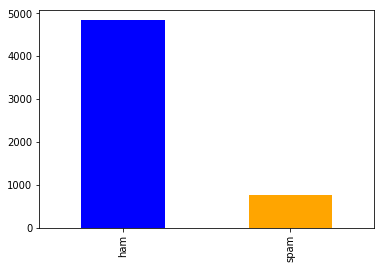

In [8]:
count_Class=pd.value_counts(data["v1"], sort= True)
print(count_Class)
count_Class.plot(kind= 'bar', color= ["blue", "orange"])
# plt.title('Bar chart')
plt.show()

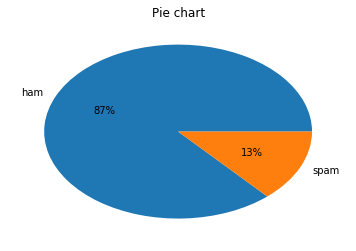

In [9]:
count_Class.plot(kind = 'pie',  autopct='%1.0f%%')
plt.title('Pie chart')
plt.ylabel('')
plt.show()

## Data Analytics

We want to find the frequencies of words in the spam and non-spam messages. The words of the messages will be model features.<p>
We use the function Counter.

In [10]:
# list all ham messages
ham_messages=data[data['v1']=='ham']["v2"]
ham_messages.head()

0    Go until jurong point, crazy.. Available only ...
1                        Ok lar... Joking wif u oni...
3    U dun say so early hor... U c already then say...
4    Nah I don't think he goes to usf, he lives aro...
6    Even my brother is not like to speak with me. ...
Name: v2, dtype: object

In [11]:
# Join all ham messages for counting
ham_words = " ".join(ham_messages).split()
ham_words[:10]

['Go',
 'until',
 'jurong',
 'point,',
 'crazy..',
 'Available',
 'only',
 'in',
 'bugis',
 'n']

In [12]:
#Number of vocabularies in ham_words
len(ham_words)

68518

### Phân tích tỉ lệ xuất hiện các từ trong các Ham/Spam emails

In [13]:
count1 = Counter(" ".join(data[data['v1']=='ham']["v2"]).split()).most_common(20)
df1 = pd.DataFrame.from_dict(count1)
df1 = df1.rename(columns={0: "words in non-spam", 1 : "count"})
df1

,words in non-spam,count
0,to,1530
1,you,1458
2,I,1436
3,the,1019
4,a,969
5,and,738
6,i,736
7,in,734
8,u,645
9,is,638


In [14]:
count2 = Counter(" ".join(data[data['v1']=='spam']["v2"]).split()).most_common(20)
df2 = pd.DataFrame.from_dict(count2)
df2 = df2.rename(columns={0: "words in spam", 1 : "count_"})
df2

,words in spam,count_
0,to,604
1,a,358
2,your,187
3,call,185
4,or,185
5,the,178
6,2,169
7,for,169
8,you,164
9,is,143


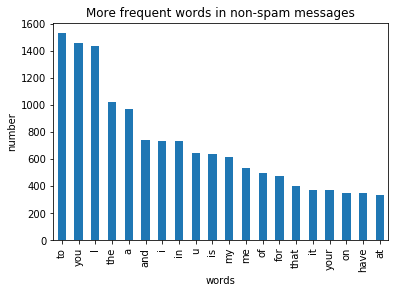

In [15]:
df1.plot.bar(legend = False)
y_pos = np.arange(len(df1["words in non-spam"]))
plt.xticks(y_pos, df1["words in non-spam"])
plt.title('More frequent words in non-spam messages')
plt.xlabel('words')
plt.ylabel('number')
plt.show()

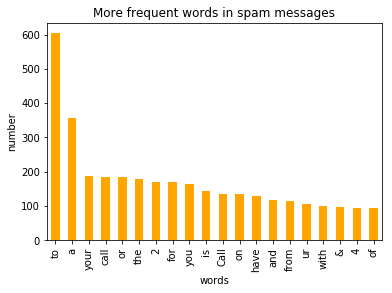

In [16]:
df2.plot.bar(legend = False, color = 'orange')
y_pos = np.arange(len(df2["words in spam"]))
plt.xticks(y_pos, df2["words in spam"])
plt.title('More frequent words in spam messages')
plt.xlabel('words')
plt.ylabel('number')
plt.show()

We can see that the majority of frequent words in both classes are stop words such as 'to', 'a', 'or' and so on. <p>
With stop words we refer to the most common words in a lenguage, there is no simgle, universal list of stop words. <p>

## Feature Engineering

Text preprocessing, tokenizing and filtering of stopwords are included in a high level component that is able to build a dictionary of features and transform documents to feature vectors.<p>
**We remove the stop words in order to improve the analytics**

In [17]:
data["v2"].head()

0    Go until jurong point, crazy.. Available only ...
1                        Ok lar... Joking wif u oni...
2    Free entry in 2 a wkly comp to win FA Cup fina...
3    U dun say so early hor... U c already then say...
4    Nah I don't think he goes to usf, he lives aro...
Name: v2, dtype: object

In [18]:
f = feature_extraction.text.CountVectorizer(stop_words = 'english')
X = f.fit_transform(data["v2"])
np.shape(X)

(5572, 8404)

In [19]:
X.shape

(5572, 8404)

In [20]:
X.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [21]:
#xem một số kí tự
X.toarray()[X.toarray()[:,0] !=0]

array([[1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]], dtype=int64)

We have created more than 8400 new features. The new feature $j$ in the row $i$ is equal to 1 if the word $w_{j}$ appears in the text example $i$. It is zero if not.

## Predictive Analysis

**My goal is to predict if a new sms is spam or non-spam. I assume that is much worse misclassify non-spam than misclassify an spam. (I don't want to have false positives)**
<p>
The reason is because I normally don't check the spam messages.<p> The two possible situations are:<p>
1. New spam sms in my inbox. (False negative).<p>
OUTCOME: I delete it.<p>
2. New non-spam sms in my spam folder (False positive).<p>  OUTCOME: I probably don't read it. <p>
I prefer the first option!!!

First we transform the variable spam/non-spam into binary variable, then we split our data set in training set and test set. 

In [22]:
data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [23]:
data["v1"]=data["v1"].map({'spam':1,'ham':0})

In [24]:
data["v1"].head()

0    0
1    0
2    1
3    0
4    0
Name: v1, dtype: int64

In [25]:
#split training/test set
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, data['v1'], test_size=0.33, random_state=42)
print([np.shape(X_train), np.shape(X_test)])

[(3733, 8404), (1839, 8404)]


### Multinomial naive bayes classifier

We train different bayes models changing the regularization parameter $\alpha$. <p>
    - Additive (Laplace/Lidstone) smoothing parameter (0 for no smoothing).
We evaluate the accuracy, recall and precision of the model with the test set.

In [26]:
# Chọn alpha
list_alpha = np.arange(1/100000, 20, 0.11)
score_train = np.zeros(len(list_alpha))
score_test = np.zeros(len(list_alpha))
recall_test = np.zeros(len(list_alpha))
precision_test= np.zeros(len(list_alpha))
count = 0
for alpha in list_alpha:
    bayes = naive_bayes.MultinomialNB(alpha=alpha)
    bayes.fit(X_train, y_train)
    score_train[count] = bayes.score(X_train, y_train)
    score_test[count]= bayes.score(X_test, y_test)
    recall_test[count] = metrics.recall_score(y_test, bayes.predict(X_test))
    precision_test[count] = metrics.precision_score(y_test, bayes.predict(X_test))
    count = count + 1 

Let's see the first 10 learning models and their metrics!

In [27]:
matrix = np.matrix(np.c_[list_alpha, score_train, score_test, recall_test, precision_test])
models = pd.DataFrame(data = matrix, columns = 
             ['alpha', 'Train Accuracy', 'Test Accuracy', 'Test Recall', 'Test Precision'])
models.head(n=10)

,alpha,Train Accuracy,Test Accuracy,Test Recall,Test Precision
0,0.00001,0.998661,0.974443,0.920635,0.895753
1,0.11001,0.997857,0.976074,0.936508,0.893939
2,0.22001,0.997857,0.977162,0.936508,0.900763
3,0.33001,0.997589,0.977162,0.936508,0.900763
4,0.44001,0.997053,0.977162,0.936508,0.900763
5,0.55001,0.996250,0.976618,0.936508,0.897338
6,0.66001,0.996518,0.976074,0.932540,0.896947
7,0.77001,0.996518,0.976074,0.924603,0.903101
8,0.88001,0.996250,0.976074,0.924603,0.903101
9,0.99001,0.995982,0.976074,0.920635,0.906250


I select the model with the most test precision

In [28]:
best_index = models['Test Precision'].idxmax()
models.iloc[best_index, :]

alpha             15.730010
Train Accuracy     0.979641
Test Accuracy      0.969549
Test Recall        0.777778
Test Precision     1.000000
Name: 143, dtype: float64

**My best model does not produce any false positive, which is our goal.** <p>
Let's see if there is more than one model with 100% precision !

In [29]:
models[models['Test Precision']==1].head(n=5)

,alpha,Train Accuracy,Test Accuracy,Test Recall,Test Precision
143,15.73001,0.979641,0.969549,0.777778,1.0
144,15.84001,0.979641,0.969549,0.777778,1.0
145,15.95001,0.979641,0.969549,0.777778,1.0
146,16.06001,0.979373,0.969549,0.777778,1.0
147,16.17001,0.979373,0.969549,0.777778,1.0


Between these models with the highest possible precision, we are going to select which has more test accuracy.

In [30]:
best_index = models[models['Test Precision']==1]['Test Accuracy'].idxmax()
bayes = naive_bayes.MultinomialNB(alpha=list_alpha[best_index])
bayes.fit(X_train, y_train)
models.iloc[best_index, :]

alpha             15.730010
Train Accuracy     0.979641
Test Accuracy      0.969549
Test Recall        0.777778
Test Precision     1.000000
Name: 143, dtype: float64

#### Confusion matrix with naive bayes classifier

In [31]:
m_confusion_test = metrics.confusion_matrix(y_test, bayes.predict(X_test))
pd.DataFrame(data = m_confusion_test, columns = ['Predicted 0', 'Predicted 1'],
            index = ['Actual 0', 'Actual 1'])

,Predicted 0,Predicted 1
Actual 0,1587,0
Actual 1,56,196


Nhận xét:
- Precision = 1 : => false positive = 0
- Recall:  77.7 %, bỏ sót 33% email spam

## Conclusion

- We misclassify 56 spam messages as non-spam emails whereas we don't misclassify any non-spam message.